## Generate Datasets

### Dataset Distribution

In order to look at the dataset distribution and evaluate its balance, I would create a dataframe with 2 columns:
- 1st column: name of the image file
- 2nd column: label for that image

In [ ]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# GET THE DIRECTORY TO THE DATASETS
path_data = '../chest_Xray/'
path_train = os.path.join(path_data, 'train')
path_val = os.path.join(path_data, 'val')
path_test = os.path.join(path_data, 'test')

# INITIATE EMPTY LIST OF TRAINING DATA
# THAT WILL BE CONVERTED TO PANDAS DATAFRAME LATER
data_train = []
data_val = []
data_test = []
data = [data_train, data_val, data_test]

# ITERATE THROUGH EACH PATH
for i, d in enumerate([path_train, path_val, path_test]):
    # GET THE PATH TO EACH FOLDER - NORMAL AND PNEUMONIA
    normal = os.path.join(d, 'NORMAL')
    pneumonia = os.path.join(d, 'PNEUMONIA')
    
    # FETCH ALL .jpeg FILES
    normal_imgs = Path(normal).glob('*.jpeg')
    pneumonia_imgs = Path(pneumonia).glob('*.jpeg')
    
    # APPEND THE NAME AND CORRESPONDING LABEL (BASED ON FOLDER NAME)
    # TO data_train list AS TUPLES
    for img in normal_imgs:
        data[i].append((str(img), 0))
    
    for img in pneumonia_imgs:
        data[i].append((str(img), 1))

In [3]:
# CONVERT data_train TO DATAFRAME FOR EASY MANIPULATION
columns = ['image', 'label']
train_df = pd.DataFrame(data_train, columns=columns)
val_df = pd.DataFrame(data_val, columns=columns)
test_df = pd.DataFrame(data_test, columns=columns)

In [4]:
# CONCAT train_df and val_df
master_df = pd.concat([train_df, val_df])

In [5]:
def cat_pneumonia_type(x):
    if 'bacteria' in x:
        output = 'bacteria'
    elif 'virus' in x:
        output = 'virus'
    else:
        output = 'normal'
    return output

In [6]:
master_df['type'] = master_df.image.apply(lambda x: cat_pneumonia_type(x))

In [7]:
master_df.type.value_counts()

type
bacteria    2538
normal      1349
virus       1345
Name: count, dtype: int64

In [8]:
train_df, val_df = train_test_split(master_df, test_size=0.2, random_state=42)

### Data Generators

In [9]:
BATCH_SIZE = 32

# CREATE GENERATOR FOR TRAINING DATA (FROM train_df DATAFRAME)
train_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    dataframe=train_df, x_col='image', y_col='label',
    color_mode='grayscale',
    class_mode='raw',
    target_size=(128,128), 
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True   # shuffle so we're not missing out on any samples
)

# CREATE GENERATOR FOR VALIDATION DATA (FROM val_df DATAFRAME)
val_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    dataframe=val_df, x_col='image', y_col='label',
    color_mode='grayscale',
    class_mode='raw',
    target_size=(128,128), 
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True
)

Found 4185 validated image filenames.
Found 1047 validated image filenames.


In [10]:
# CHECKING THE SHAPE OF 1 BATCH OF THE train_generator
images_train, labels_train = next(train_generator)
print(f'Training set: {images_train.shape} | {labels_train.shape}')

Training set: (32, 128, 128, 1) | (32,)


## Modeling

In [11]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.metrics import Recall, Precision
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers.schedules import ExponentialDecay
import matplotlib.pyplot as plt

### Baseline Model

Baseline Convolution Neural Networks (CNN) model with:

- One 2D Convolution layer with padding (same) and ReLU activation
- One 2D MaxPooling layer
- A Flatten layer to convert the 2D feature maps into a 1D vector
- One hidden Dense (fully connected) layer with ReLU activation
- One output Dense layer with a sigmoid activation for binary classification



In [12]:
baseline = Sequential()
baseline.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=[128,128,1]))
baseline.add(MaxPooling2D(pool_size=(2,2)))
baseline.add(Flatten())
baseline.add(Dense(32, activation='relu'))
baseline.add(Dense(1, activation='sigmoid'))

/home/corentin/.pyenv/versions/3.10.12/envs/test/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749563000.974122   46324 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4151 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [13]:
recall = Recall()
precision = Precision()

In [14]:
baseline.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy', recall, precision])

In [15]:
baseline.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     4,194,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,194,689 (16.00 MB)

 Trainable params: 4,194,689 (16.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_cb = ModelCheckpoint('baseline.h5',
                                save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

BATCH_SIZE = 32
EPOCHS = 30

results_1 = baseline.fit(train_generator, 
                         validation_data=val_generator,
                         epochs=EPOCHS,
                         steps_per_epoch=(train_generator.n//BATCH_SIZE),
                         validation_steps=(val_generator.n//BATCH_SIZE),
                         callbacks=[checkpoint_cb, early_stopping_cb])

/home/corentin/.pyenv/versions/3.10.12/envs/test/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1749563006.387032   47105 service.cc:152] XLA service 0x7d5c400164d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749563006.387062   47105 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-06-10 15:43:26.460279: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749563006.880925   47105 cuda_dnn.cc:529] Loaded cuDNN version 90800


  2/130 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.2812 - loss: 1.0957 - precision: 0.3750 - recall: 0.2308         

I0000 00:00:1749563009.943535   47105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7085 - loss: 0.7755 - precision: 0.7476 - recall: 0.9187

130/130 ━━━━━━━━━━━━━━━━━━━━ 67s 472ms/step - accuracy: 0.7087 - loss: 0.7749 - precision: 0.7476 - recall: 0.9191 - val_accuracy: 0.7227 - val_loss: 0.6708 - val_precision: 0.7227 - val_recall: 1.0000
Epoch 2/30
  1/130 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.6875 - loss: 0.6746 - precision: 0.6875 - recall: 1.0000

/home/corentin/.pyenv/versions/3.10.12/envs/test/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.6875 - loss: 0.6746 - precision: 0.6875 - recall: 1.0000 - val_accuracy: 0.7227 - val_loss: 0.6706 - val_precision: 0.7227 - val_recall: 1.0000
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.7528 - loss: 0.6611 - precision: 0.7528 - recall: 1.0000

130/130 ━━━━━━━━━━━━━━━━━━━━ 53s 409ms/step - accuracy: 0.7528 - loss: 0.6610 - precision: 0.7528 - recall: 1.0000 - val_accuracy: 0.7227 - val_loss: 0.6501 - val_precision: 0.7227 - val_recall: 1.0000
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.7500 - loss: 0.6441 - precision: 0.7500 - recall: 1.0000 - val_accuracy: 0.7207 - val_loss: 0.6504 - val_precision: 0.7207 - val_recall: 1.0000
Epoch 5/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.7605 - loss: 0.6363 - precision: 0.7605 - recall: 1.0000

130/130 ━━━━━━━━━━━━━━━━━━━━ 54s 415ms/step - accuracy: 0.7604 - loss: 0.6363 - precision: 0.7604 - recall: 1.0000 - val_accuracy: 0.7227 - val_loss: 0.6339 - val_precision: 0.7227 - val_recall: 1.0000
Epoch 6/30
  1/130 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9375 - loss: 0.5640 - precision: 0.9375 - recall: 1.0000

130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.9375 - loss: 0.5640 - precision: 0.9375 - recall: 1.0000 - val_accuracy: 0.7236 - val_loss: 0.6335 - val_precision: 0.7236 - val_recall: 1.0000
Epoch 7/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.7398 - loss: 0.6240 - precision: 0.7398 - recall: 1.0000

130/130 ━━━━━━━━━━━━━━━━━━━━ 54s 415ms/step - accuracy: 0.7399 - loss: 0.6240 - precision: 0.7399 - recall: 1.0000 - val_accuracy: 0.7266 - val_loss: 0.6195 - val_precision: 0.7266 - val_recall: 1.0000
Epoch 8/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.7812 - loss: 0.5964 - precision: 0.7812 - recall: 1.0000 - val_accuracy: 0.7188 - val_loss: 0.6228 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 9/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.7413 - loss: 0.6104 - precision: 0.7413 - recall: 1.0000

130/130 ━━━━━━━━━━━━━━━━━━━━ 53s 408ms/step - accuracy: 0.7413 - loss: 0.6104 - precision: 0.7413 - recall: 1.0000 - val_accuracy: 0.7207 - val_loss: 0.6128 - val_precision: 0.7207 - val_recall: 1.0000
Epoch 10/30
  1/130 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.7812 - loss: 0.5819 - precision: 0.7812 - recall: 1.0000

In [ ]:
def visualize_training_results(results):
    history = results.history
    
    for m in ['loss', 'accuracy', 'precision', 'recall']:
        plt.figure(figsize=(15,5))
        plt.plot(history[m], label='Training', marker='o', color='blue')
        plt.plot(history[f'val_{m}'], label='Validation', marker='o', color='red')
        plt.xlabel('Epochs')
        plt.legend()
        plt.title(m.title())
    
    plt.show();

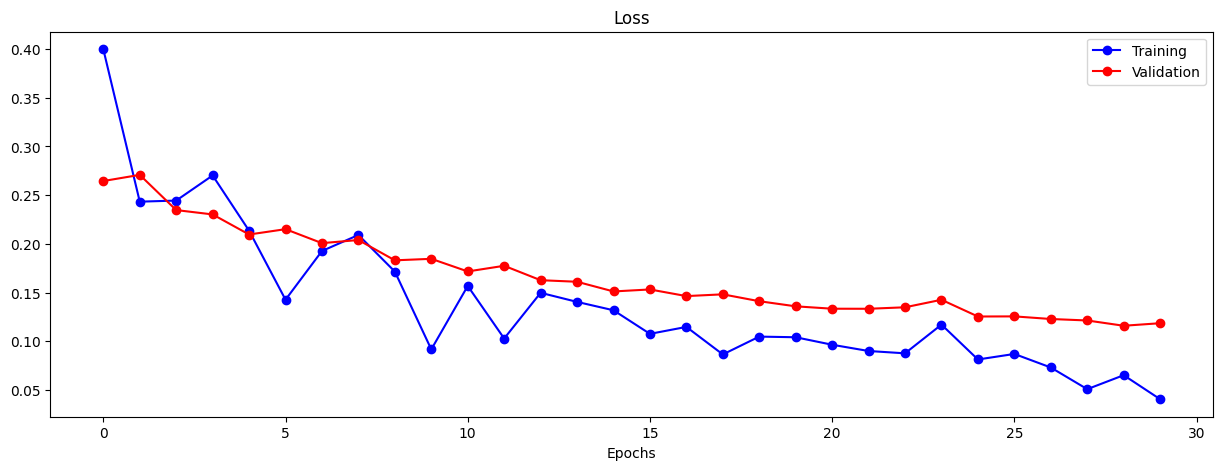

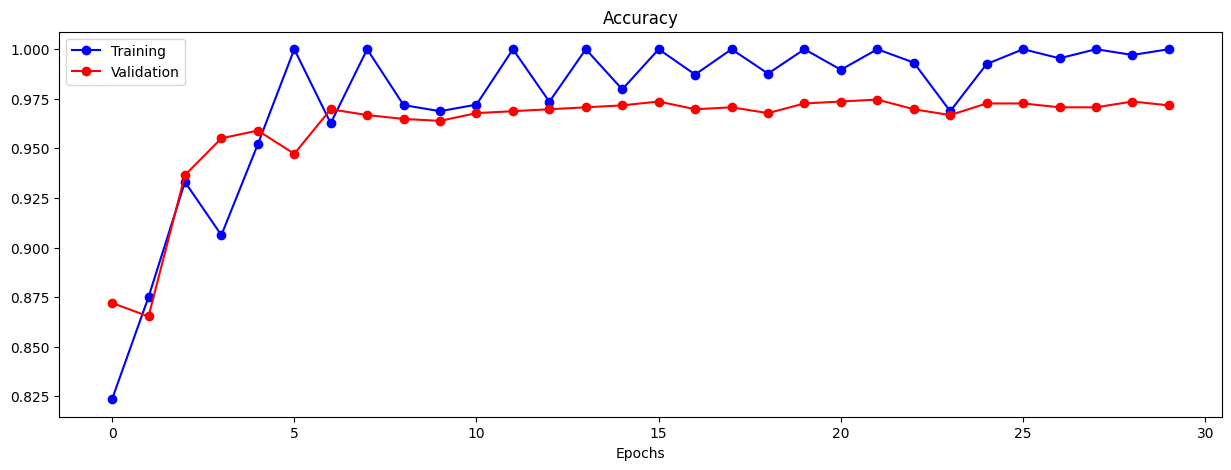

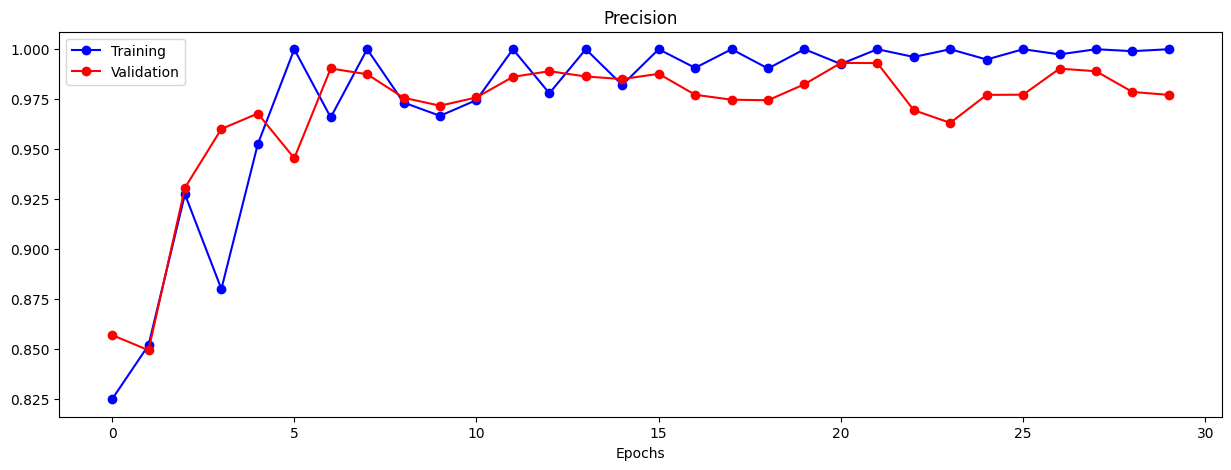

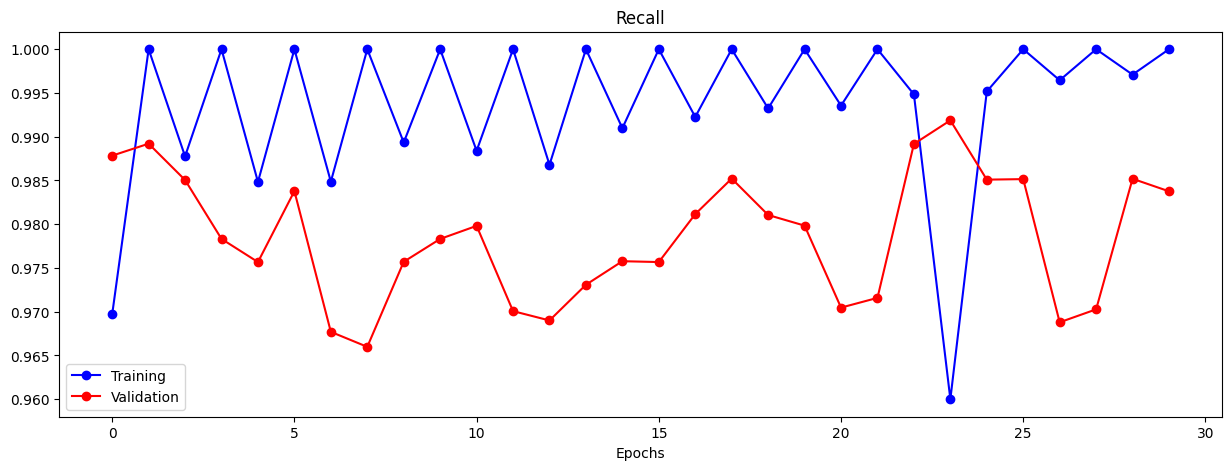

In [ ]:
visualize_training_results(results_1)